In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime

from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, plot_precision_recall_curve, precision_recall_curve, precision_score, recall_score

from sklearn.model_selection import RandomizedSearchCV, train_test_split
import shap
import lightgbm as lgb 

pd.set_option('max_colwidth', 80)

ModuleNotFoundError: No module named 'shap'

In [ ]:
df = pd.read_csv('final_data.csv') 
df.head()

In [ ]:
df['Target'].unique()

In [ ]:
df_2014 = df[df['Process_year'] == 2014]
df_2014.shape

In [ ]:
df_2014['Break_Yr'].unique()

In [ ]:
columns = df_2014.columns.drop(['TARGET_FID', 'Process_year', 'Break_Yr'])
df_2014_cols = df_2014[columns]
print(df_2014_cols.shape)
#df_2014_cols_cleaned = df_2014_cols[~df_2014_cols.isin([np.nan, np.inf, -np.inf]).any(1)].astype(np.float32) # removes rows with nan or inf points
df_2014_cols_cleaned = df_2014_cols.dropna(axis=0).astype(np.float32) # removes rows with nan or inf points
print(df_2014_cols_cleaned.shape)


In [ ]:
features_df = df_2014_cols_cleaned.drop('Target', axis=1)
target_df = df_2014_cols_cleaned[['Target']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2)

In [11]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [12]:
preds = etc.predict(X_test)
probs = etc.predict_proba(X_test)
bal_acc = balanced_accuracy_score(y_pred=preds, y_true=y_test)
recall = recall_score(y_true=y_test, y_pred=preds)
precision = precision_score(y_true=y_test, y_pred=preds)
print(bal_acc)
print(recall)
print(precision)

0.7190864095475665
0.43902439024390244
0.6428571428571429


In [13]:
confusion_matrix(y_test, preds)

array([[11733,    10],
       [   23,    18]])

array([ 6,  0,  1, 50,  5,  3, 51,  2,  4, 21, 28, 48, 29, 44, 30, 40, 12,
       46, 49, 24, 32, 33, 41, 45, 23, 15, 16, 43, 11,  9, 10, 19, 17, 47,
       39, 35, 31, 34, 13, 37,  7, 26, 22, 36, 14, 25, 20, 18, 38,  8, 42,
       27])

In [14]:
importances = etc.feature_importances_
std = np.std([tree.feature_importances_ for tree in etc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    feature_name = features[indices[f]]
    print(feature_name)
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print()

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Feature ranking:


NameError: name 'features' is not defined

### XGBoost

In [82]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [21]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [23]:
# set param
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

# train
bst = xgb.train(param, dtrain)

In [76]:
dtest = xgb.DMatrix(X_test)
ypred = bst.predict(dtest)
preds = np.where(ypred > 0.5, 1, ypred)
preds = np.where(preds <= 0.5, 0, preds)
preds.min()

0.0

In [78]:
# compare scores
bal_acc = balanced_accuracy_score(y_pred=preds, y_true=y_test)
recall = recall_score(y_true=y_test, y_pred=preds)
precision = precision_score(y_true=y_test, y_pred=preds)
print(bal_acc)
print(recall)
print(precision)

0.6666240953597276
0.3333333333333333
0.9285714285714286


In [79]:
confusion_matrix(y_test, preds)

array([[11744,     1],
       [   26,    13]])

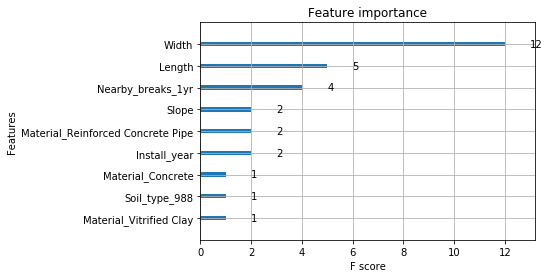

In [80]:
xgb.plot_importance(bst)